<a href="https://colab.research.google.com/github/mtue04/spam-filter-using-naive-bayes-classifier/blob/main/spam_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Tue Phan Vo Minh (Dylan Phan)

# SPAM FILTER USING NAIVE BAYES CLASSIFIER

## Prepare dataset
Dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tuephanvominh","key":"70443a03558430d5046ec045813f7c98"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 32.3MB/s]


In [6]:
# unzip sms-spam-collection-dataset.zip
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


## Importing libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [8]:
# Read csv file
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']

## EDA

In [9]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [11]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

<Axes: xlabel='label', ylabel='count'>

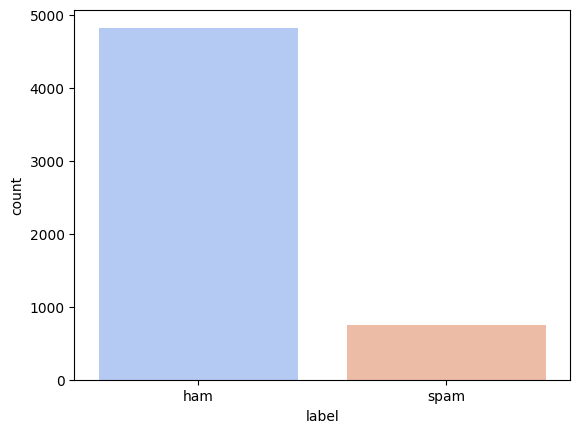

In [12]:
sns.countplot(data=df, x='label', hue='label', palette='coolwarm')

## Clean and normalize text
Here, we will do the following steps:
1. Remove any special characters and digits
2. Convert all characters to lowercase
3. Remove extra whitespace
4. Remove stopwords
5. Perform stemming or lemmatization

In [13]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def pre_process_text(text):
    '''
    Function to pre-process text data for mail spam filter model using the following steps:
        1. Remove special characters and digits
        2. Convert all characters to lowercase
        3. Remove extra whitespace
        4. Remove stopwords
        5. Perform stemming or lemmatization

    Parameters:
        text: str: text data to be pre-processed

    Returns:
        text: str: pre-processed text data
    '''
    text = re.sub('[^a-zA-Z]', ' ', text)

    text = text.lower()

    tokens = word_tokenize(text)
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(processed_tokens)

In [15]:
df['processed_message'] = df['message'].apply(pre_process_text)

## Convert text into vectors (using bag of words model)
1. Create a vocabulary from all unique words in the dataset
2. Use CountVectorizer or TfidfVectorizer from scikit-learn to convert text to numerical vectors
3. Consider using n-grams (e.g., bigrams or trigrams) to capture phrases
4. Optionally, apply feature selection techniques to reduce the dimensionality of the feature space

In [16]:
def vectorize_text(df, vectorizer_type='count', ngram_range=(1, 1), max_features=None, max_df=1.0, min_df=1, use_idf=True):
    '''
    Vectorize the text data using either CountVectorizer or TfidfVectorizer.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'processed_message' column
    vectorizer_type (str): 'count' for CountVectorizer, 'tfidf' for TfidfVectorizer
    ngram_range (tuple): Range of n-grams to consider
    max_features (int): Maximum number of features (vocabulary size)
    max_df (float): Ignore terms that have a document frequency higher than this threshold
    min_df (int): Ignore terms that have a document frequency lower than this threshold
    use_idf (bool): Only applicable for TfidfVectorizer. Whether to use inverse document frequency

    Returns:
    X (scipy.sparse.csr_matrix): Vectorized text
    vectorizer (sklearn vectorizer object): Fitted vectorizer
    '''
    if vectorizer_type == 'count':
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features, max_df=max_df, min_df=min_df)
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features, max_df=max_df, min_df=min_df, use_idf=use_idf)
    else:
        raise ValueError("Invalid vectorizer_type. Choose 'count' or 'tfidf'.")

    X = vectorizer.fit_transform(df['processed_message'])
    return X, vectorizer

def select_features(X, y, k=1000):
    '''
    Perform feature selection using chi-squared test.

    Parameters:
    X (scipy.sparse.csr_matrix): Vectorized text
    y (array-like): Target labels
    k (int): Number of top features to select

    Returns:
    X_new (scipy.sparse.csr_matrix): Transformed feature matrix
    selector (SelectKBest): Fitted feature selector
    '''
    selector = SelectKBest(chi2, k=k)
    X_new = selector.fit_transform(X, y)
    return X_new, selector

In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['processed_message'], df['label'], test_size=0.2, random_state=42)

# Vectorize the data
X_train_vectorized, vectorizer = vectorize_text(
    pd.DataFrame({'processed_message': X_train}),
    vectorizer_type='tfidf',
    ngram_range=(1, 2),
    max_features=5000,
    max_df=0.95,
    min_df=2
)

# Apply the same vectorization to the test set
X_test_vectorized = vectorizer.transform(X_test)

# Perform feature selection
X_train_selected, selector = select_features(X_train_vectorized, y_train, k=1000)
X_test_selected = selector.transform(X_test_vectorized)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"X_train shape after vectorization: {X_train_vectorized.shape}")
print(f"X_train shape after feature selection: {X_train_selected.shape}")

Vocabulary size: 5000
X_train shape after vectorization: (4457, 5000)
X_train shape after feature selection: (4457, 1000)


## Train and test Classifier:
1. Split the dataset into training and testing sets (80% training, 20% testing)
2. Choose the Naive Bayes variant (Multinomial Naive Bayes for text classification)
3. Train the classifier on the training data
4. Make predictions on the test set
5. Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score
6. Perform cross-validation to ensure the model's stability
7. Fine-tune hyperparameters (if necessary)
8. Analyze misclassifications to understand where the model is making mistakes

In [18]:
def train_and_evaluate_naive_bayes(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Perform cross-validation
    cv_scores = cross_val_score(clf, X, y, cv=5)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}")

    # Fine-tune hyperparameters
    param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
    grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Use the best model
    best_clf = grid_search.best_estimator_
    y_pred_best = best_clf.predict(X_test)

    # Analyze misclassifications
    cm = confusion_matrix(y_test, y_pred_best)
    print("\nConfusion Matrix:")
    print(cm)

    # Identify misclassified samples
    misclassified = X_test[y_test != y_pred_best]
    # Use shape[0] to get the number of rows (misclassified samples)
    print(f"\nNumber of misclassified samples: {misclassified.shape[0]}")

    return best_clf, misclassified

In [19]:
best_model, misclassified_samples = train_and_evaluate_naive_bayes(X_train_selected, y_train)

print("\nSample of misclassified messages:")

for message in misclassified_samples[:5]:
    print(message)

Model Performance:
Accuracy: 0.9226
Precision: 0.9288
Recall: 0.9226
F1 Score: 0.9032

Cross-validation scores: [0.91143498 0.90022422 0.90347924 0.8989899  0.90796857]
Mean CV score: 0.9044

Best parameters: {'alpha': 0.1}
Best cross-validation score: 0.9658

Confusion Matrix:
[[793   1]
 [ 26  72]]

Number of misclassified samples: 27

Sample of misclassified messages:
  (0, 799)	0.416035080764705
  (0, 744)	0.23908379530112261
  (0, 63)	0.16735066013601752
  (0, 117)	0.6349004355669269
  (0, 949)	0.5082258773991727
  (0, 116)	0.5819002444223303
  (0, 817)	0.2796347523065296
  (0, 122)	0.2106957459349947
  (0, 810)	0.2662587578316784
  (0, 158)	0.19844446074333522
  (0, 768)	0.1721439722597769
  (0, 373)	0.1678286516980653
  (0, 809)	0.3200156470561781
  (0, 535)	0.7186999076861751
  (0, 534)	0.4396967630665238
  (0, 63)	0.29737595421164736
  (0, 359)	0.6197366730250382


## Main

In [20]:
def predict_spam(text):
    # Pre-process the input text
    processed_text = pre_process_text(text)

    # Vectorize the pre-processed text
    text_vectorized = vectorizer.transform([processed_text])

    # Apply feature selection
    text_selected = selector.transform(text_vectorized)

    # Make a prediction
    prediction = best_model.predict(text_selected)

    result = 'spam' if prediction[0] == 'spam' else 'not spam'
    prediction_rate = best_model.predict_proba(text_selected)[0][1]
    prediction_rate = round(prediction_rate * 100, 2)
    return result, prediction_rate

In [21]:
new_message = 'Your cash-balance is currently 500 pounds - to maximize your cash-in now, send COLLECT to 83600.'

result, prediction_rate = predict_spam(new_message)
print(f"Prediction: {result} with {prediction_rate}%")

Prediction: spam with 93.74%
